==============================================================================================
# Practicum 6 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Group A- Group F): December 10th, 23:00 h**

**Deadline (Group B): December 11th, 23:00 h**

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

Today's exercices will practise the following:

- Integral images and a classical use for fast harr-like feature computation.
- Use of Adaboost for classification.
- Decisions based on a user-defined threshold for balancing precision and recall.

## Imports

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from skimage import io
from time import time

import skimage
from skimage.feature import haar_like_feature
from skimage.transform import resize
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from sklearn.model_selection import train_test_split



# Wrapper function to easily use subplot    
import math
def print_images(images, titles=None, ncols=None, colormap=None):
    if ncols == None: #If no number of columns is given, we will print everything in one row
        ncols = len(images)
    if titles == None or len(titles) != len(images): #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in range(len(images))]
    
    nrows = math.ceil(len(images)/ncols) #Compute the number of rows required to print everythong in ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(18,8)) #Generate subplot
    
    #Switch off every axis
    for x in ax.ravel():
        x.axis("off")
        
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j >= len(images): #Stop if every image has been printed, even if the grid is not "complete"
                break;
            ax[i,j].imshow(images[i*ncols + j], cmap=colormap) #Set subplot with given colormap
            ax[i,j].set_title(titles[i*ncols + j])
    plt.show() #Show subplots
    return

# RGB convolution
def convolute_rgb(im, mask):
    im_conv = img_as_ubyte(rgba2rgb(im)) #Convert the image to rgb and to uint (we could also convolute as float)
    for i in range(3): #For each channel
        im_conv[..., i] = convolve(im_conv[...,i], mask) #Do a 2D convolution with selected mask
    return im_conv

#Function to easily print image details
def print_im_detail(image):
    print('Type: ', image.dtype, ' Min.value: ', image.min(), ' Max.value: ', image.max(), ' Image shape: ', image.shape)
    
#Normalization function
def normalize(image):
    return (image.copy()-image.min())/(image.max()-image.min())

## Haar-like feature descriptor for face detection

### What is a Haar-like feature?

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### Face detection

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)


In this work we are going to see:


1. What is a Haar-like feature?
2. Build Integral image
3. Extract Haar features
4. The Adaboost Classifier
5. Face detection with cascade classifier

### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=2500>

An example :

<img src="notebook_images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array.

The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

In [2]:
def to_integral_image(img_arr):
    
    #Generate an array oz zeros with one extra row and col
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    #Traverse the whole image
    for i in range(img_arr.shape[0]):
        for j in range(img_arr.shape[1]):
            #Notice that the indices are incremented by one, as we have an extra column and row of zeros.
            # To compute the value, we get the value on its upper left corner, add the sum of the current column,
            # add the sum of the current row and subtract the value of the pixel (as it is added in both the col and row sum)
            integral_image_arr[i+1,j+1] = integral_image_arr[i, j] + np.sum(img_arr[i][:j+1]) + np.sum(img_arr[:,j][:i+1]) - img_arr[i, j]
    
    
    return integral_image_arr

**1.2** Construct a binary image of dimensiones 5x5 and visualize it together with its integral image.

Original image:
 [[2 0 1 1 0]
 [0 1 2 2 0]
 [0 1 2 2 0]
 [0 2 2 0 0]
 [2 0 1 1 0]]
Our integral image:
 [[ 0.  0.  0.  0.  0.  0.]
 [ 0.  2.  2.  3.  4.  4.]
 [ 0.  2.  3.  6.  9.  9.]
 [ 0.  2.  4.  9. 14. 14.]
 [ 0.  2.  6. 13. 18. 18.]
 [ 0.  4.  8. 16. 22. 22.]]
Numpy integral image:
 [[ 2  2  3  4  4]
 [ 2  3  6  9  9]
 [ 2  4  9 14 14]
 [ 2  6 13 18 18]
 [ 4  8 16 22 22]]


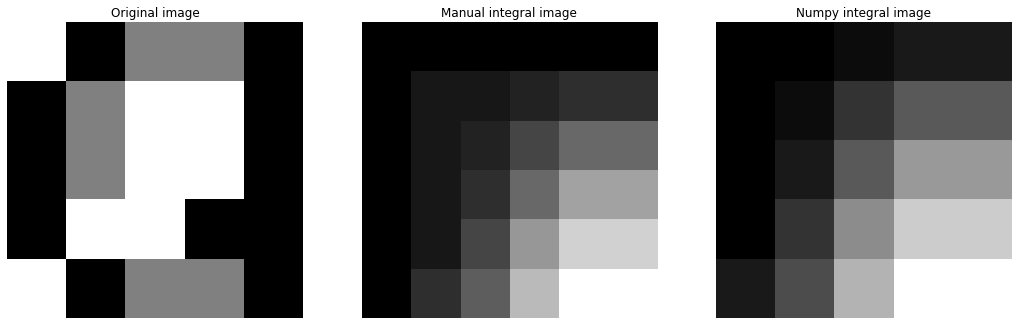

In [121]:
#Create random images
img_array = np.ones((5,5))
img_array = np.random.randint(3, size=(5,5))

#Compute the integral image both 
ii_img_array = to_integral_image( img_array )
numpy_ii_img = img_array.cumsum(axis=0).cumsum(axis=1) #The efficient way using numpy, just using the cumulative sum method twice

#print them
print("Original image:\n", img_array)
print("Our integral image:\n", ii_img_array)
print("Numpy integral image:\n", numpy_ii_img)
print_images([img_array, ii_img_array, numpy_ii_img], ["Original image", "Manual integral image", "Numpy integral image"])

As we can see, our integral image contains an extra row and col of zeros. We can also see that our iterative method gives the same result (except for those two rows) as the much easier numpy method

**1.3** Integral image test

To make sure that the values of the integral image are correct, compute the following tests:

 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [122]:
# Your solution here
print(img_array.sum() == ii_img_array[-1,-1])
print(img_array[0,:].sum() == ii_img_array[1,-1])

True
True


**1.4** Let's check in real images.

Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

In [123]:
#Load the image and compute it's integral image
face = io.imread("./faces/face00001.png")
integral_face = to_integral_image(face)

#We can check that the integral image has one col and one row more than the original image
print_im_detail(face)
print_im_detail(integral_face)

#Print them
print_images([face, integral_face])

#Run the tests of the previous exercice
print(face.sum() == integral_face[-1,-1])
print(face[0,:].sum() == integral_face[1,-1])


Type:  uint8  Min.value:  54  Max.value:  189  Image shape:  (19, 19)
Type:  float64  Min.value:  0.0  Max.value:  41508.0  Image shape:  (20, 20)


True
True


**1.5** What do the following lines mean? How can you explain this?

 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 - `ii_img_array[0,-1].sum() == 0`
 


# Answer
- Test whether the sum of all pixels of the image is equal to the bottom right pixel of the integral image, which should contain the sum of every pixel. (To properly work, this should be img_array.sum(), sum(img_array) sums the columns independently)
- Test if the sum of the first row is the last element form the second row of the integral image
- Test if the first row contains only zeros

We can test them, but these are directly true by the definition of integral image:

In [124]:
print(img_array.sum() == ii_img_array[-1,-1])
print(img_array[0,:].sum() == ii_img_array[1,-1])
print(ii_img_array[0,-1].sum() == 0)

True
True
True


**1.6: (Optional)** Alternatively to your own function, you can use the function of skimage ``skimage.transform import integral_image``. 

Compare the result obtained using your funtion and that obtained using the function provided by skimage.

In [7]:
# Your solution here

## 2. Haar-like features

Let's use the haar_like_feature function from skimage [Haar like feature](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature)

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*

Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing.

###  Extract features

**2.1** Once we have the function to get the integral image, we can extract the features before building the classifier.

Define a function ``extract_feature_image`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image.


In [8]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [112]:
def extract_feature_image(image, feature_type, feature_coord=None):
    integral_image = to_integral_image(image) #Compute the integral image
    features = skimage.feature.haar_like_feature(integral_image, r=0, c=0, width=image.shape[1], height=image.shape[0], feature_type=feature_type) #Get the features
    return features

Try your function using the choosing image from *1.4*. 

**Note:** You have to obtain a feature vector. Print the vector shape.

In [113]:
features = extract_feature_image(face, feature_types)
print(features.shape)

(63666,)


**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- *skimage.feature.haar_like_feature_coord(width, height, feature_type=None)*

- *skimage.feature.draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*


Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``.

In [11]:
# Your solution here 

#There are thousands of features, we just plot some random ones with types in feature_types
def plot_features(image, feature_types=None, n_filters=8):
    # Get feature coordinates ant types restricted to feature_types
    feature_coord, feature_type = skimage.feature.haar_like_feature_coord(width=image.shape[0], height=image.shape[1], feature_type=feature_types)

    #Select n random indices
    indices = np.random.randint(feature_type.shape[0], size=(n_filters))
    
    #Plot the randomly selected features
    fig, axes = plt.subplots(1, n_filters, figsize=(15,5))
    fig.suptitle("%i random Haar-like feature descriptors" % n_filters)
    for idx, ax in enumerate(axes.ravel()):
        img = draw_haar_like_feature(image, 0, 0, image.shape[1], image.shape[0], [feature_coord[indices[idx]]])
        ax.imshow(img)
        ax.set_title(feature_type[indices[idx]])
        ax.set_xticks([])
        ax.set_yticks([])
        

Try your function using the choosing image from *1.4* as follows:
<img src="notebook_images/image1.png" width=600, height=300>

In [62]:
plot_features(face, feature_types)

### 3 Preparing the Dataset

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [13]:
# Build a vector with the faces features
path = "./faces/"                       
face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

features_faces = [extract_feature_image(image, feature_types) for image in face_images]

In [14]:
# Build a vector with the non-faces features
path = "./nonfaces/"                       
non_face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

non_features_faces = [extract_feature_image(image, feature_types) for image in non_face_images]

In [15]:
x = np.array(features_faces + non_features_faces) #We just concatenate the faces and non_faces features
y = np.concatenate((np.ones(len(features_faces)), np.zeros(len(non_features_faces)))) #And create and array with len(features_face) ones and len(non_features_faces) zeros
# Labels face = 1, non face = 0

**3.2** Using the function ``train_test_split`` from sklearn, divide the dataset into *train* and *test* set

In [16]:
# Divide the dataset 
x_train, x_test, y_train, y_test = train_test_split(x, y)

### 4  Adaboost training

**4.1** Train an Adaboost classifier using:

*class sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*

What is an Adaboost doing?

Adaboost (which means Adaptative Boosting) is a classification algorithm that works by joining several wak classifiers into a single good classifier. In each iteration and for all features, we consider the threshold that best separates the two distinct classes. In the first iteration, we take the feature that separates the classes with the minimum error and add that feature to our classifier. At the following iterations, we will use the remaining features and see which one separates the data with minimum error, but we will compute the thresholds using the features and thresholds chosen in prevoius iterations. With this method, at each iteration the best classifier should correctly classify the missclassified data by the previous iterations, thus refining our final classifier.

In [110]:
from sklearn.ensemble import AdaBoostClassifier

# Declare the classifier and train it
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
clf.fit(x_train, y_train)

AdaBoostClassifier()

**4.2** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [109]:
pred = clf.predict(x_test) #Make a prediction and print the output and real classification
print("Prediction:\t", pred)
print("Real:\t\t", y_test)
print("Score: ", clf.score(x_test, y_test)) #Print the score 

Prediction:	 [1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
Real:		 [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
Score:  0.9411764705882353


Change the parameter ``n_estimators`` and see what happens. Does it improve?

## Answer
It doesen't seem to improve if we increase it or decrease it a bit, however id does get worse if we decrease it a lot. It seems that at 40 estimators reaches the maximmum.

**4.3** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

(63666,)


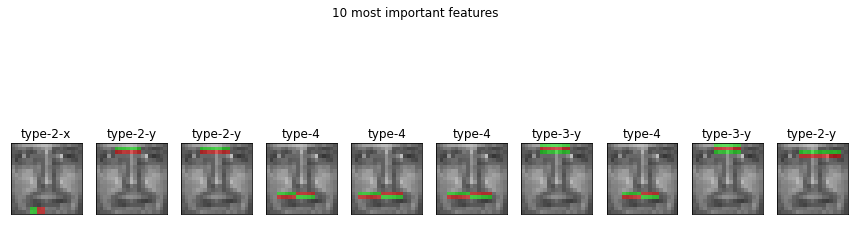

In [65]:
# Your solution here
#THe function takes the image we want to find features for, the classifier object itself ant optionaly the number of features to show.
def plot_best_features(image, classifier, n_features=10):
    
    #We get the coordinates and types of each feature
    feature_coord, feature_type = skimage.feature.haar_like_feature_coord(width=image.shape[0], height=image.shape[1], feature_type=feature_types)

    #Sort the indices by importance, reverse them (so the most important are at the front) and take the n first.
    indices = np.argsort(classifier.feature_importances_)[::-1][:n_features]
    
    #Print the images with each feature superposed
    fig, axes = plt.subplots(1, n_features, figsize=(15,5))
    fig.suptitle("%i most important features" % n_features)
    for idx, ax in enumerate(axes.ravel()):
        img = draw_haar_like_feature(image, 0, 0, image.shape[1], image.shape[0], [feature_coord[indices[idx]]])
        ax.imshow(img)
        ax.set_title(feature_type[indices[idx]])
        ax.set_xticks([])
        ax.set_yticks([])

plot_best_features(face_images[0], clf)

**4.4**  Try the Adabost classifier using other faces and non-faces images. What is the result? 

In [91]:
# Your solution here
from skimage import img_as_int

#Make the prediction using the features of non_faces
predictions = clf.predict(non_features_faces)
print("Predictions of non_faces directory:\n\t", predictions)

# Load images from other faces directory
path = "./another_faces/"                       
original_another_faces = [skimage.io.imread(path + f) for f in os.listdir(path)]

#We have to resize them, convert to grayscale and int 
another_faces = [img_as_int(rgb2gray(resize(image, (19,19)))) for image in original_another_faces]

#Extract features
features = [extract_feature_image(image, feature_types) for image in another_faces]

#Make prediction
predictions = clf.predict(features)
print("Predictions of other faces directory:\n\t", predictions)


Predictions of non_faces directory:
	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Predictions of other faces directory:
	 [1. 0. 1. 0. 1. 1. 1. 1.]


## Answer
We can see that the classifier identifies all non faces correctly. However, it doesen't do so well in the other faces directory. Probably the distortion applied by reescaling and the fact that the images contain background (while the images in faces directory contained only faces) has something to do with the missing ones.

**4.5 (Optional)** Implement the Adaboost training the model with just 1 type of feature. And 2 types? And 3 types? Plot the results comparing the precision. Draw conclusions about the results

In [22]:
# Your solution here

### 5. Cascade of classifiers

The Cascade Adaboost is implemented in the class ``skimage.feature.Cascade``.

**5.1** Compare the performance of the Cascade classifier  and your Adaboost classifier from point 4 on the folder *another_faces*. Show the detected faces by both classifiers and compare their score.

<img src="notebook_images/cascade.png" width=300, height=300>


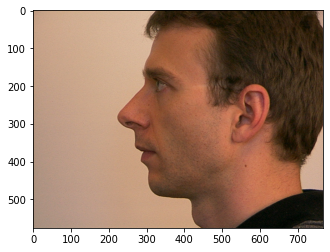

In [30]:
from skimage.feature import Cascade
from skimage import data
from matplotlib import patches

# Load face images
path = "./another_faces/"                       
original_another_faces = [skimage.io.imread(path + f) for f in os.listdir(path)]

# Load the Cascade trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the dectector cascade
query = original_another_faces[1]
detector = Cascade(trained_file)
detected = detector.detect_multi_scale(img=query, scale_factor=1.2, step_ratio=1, min_size=(50, 50),
                                       max_size=(500, 500))

plt.imshow(query)
img_desc = plt.gca()
plt.set_cmap('gray')

for patch in detected:

    img_desc.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

In [93]:
#As the above code just works for a single image, we created a function that takes an array of images, runs them
# through the classifier and returns the indices where the image is recognized as a face.

def face_cascade(query, trained_file=None):
    if not isinstance(query, list): #Check if it's actually a list, print error message and return otherwise
        print("Query should be an iterable!")
        return 
    
    #If no trained file is specified just use the default one
    if trained_file == None:
        trained_file = data.lbp_frontal_face_cascade_filename()

    #Declare the cascade of classifiers using the trained file
    detector = Cascade(trained_file)

    faces = [] #An array to store the indices of the faces
    for i in range(len(query)):
        #For each image check if there's a face in multiple scales
        detected = detector.detect_multi_scale(img=query[i], scale_factor=1.2, step_ratio=1, min_size=(50, 50), max_size=(500, 500))

        #Check if a face is actually detected
        if len(detected) == 0:
            print("No face detected at index %i" % i)
        else:
            #Print the face and the areas where it's detected
            print("Face detected at index %i" % i)
            plt.imshow(query[i])
            img_desc = plt.gca()
            plt.set_cmap('gray')

            for patch in detected:

                img_desc.add_patch(
                    patches.Rectangle(
                        (patch['c'], patch['r']),
                        patch['width'],
                        patch['height'],
                        fill=False,
                        color='r',
                        linewidth=2
                    )
                )
            plt.show()
            faces.append(i) #Save the index

    return faces #Return array of indices
        
        

No face detected at index 0
No face detected at index 1
Face detected at index 2


Face detected at index 3


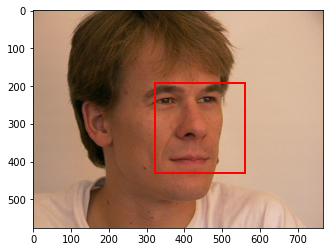

No face detected at index 4
Face detected at index 5


No face detected at index 6
Face detected at index 7


4 out of 8 images (a 50%) are detected as faces


In [95]:
#Test the code. We first obtain the indices where faces are found
faces = face_cascade(original_another_faces)
print("%i out of %i images (a %i%%) are detected as faces" % (len(faces), len(original_another_faces), len(faces)/len(original_another_faces)*100))

#And then print those images
print_images([original_another_faces[i] for i in faces])

6 out of 8 images (a 75%) are detected as faces


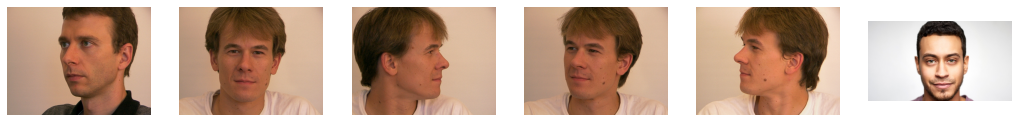

In [83]:
# We just repeat the test we did in exercise 4.4


from skimage import img_as_int

another_faces = [img_as_int(rgb2gray(resize(image, (19,19)))) for image in original_another_faces]

features = [extract_feature_image(image, feature_types) for image in another_faces]
predictions = clf.predict(features)
faces = [i for i in range(len(predictions)) if predictions[i] == 1]


print("%i out of %i images (a %i%%) are detected as faces" % (len(faces), len(original_another_faces), len(faces)/len(original_another_faces)*100))
print_images([original_another_faces[i] for i in faces])

## Answer
We can see that the adaboost classifier is a bit better than the cascade classifier (6/8 vs 4/8 faces detected). We have to keep in mind that the cascade used a trained file with only frontal pictures of faces, but the adaboost was only trained using frontal shoots. We don't know the data on which the cascade was trained, so a fairer comparison would have been to train both classifiers using the same dataset. 